### Import libraries

Firstly, we have to import all necessary libraries.

### Main functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pathlib import Path
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

Once we have the excel containing the features extracted and the labels according to the variables that we want to look into, some steps have to be followed. The first part consists on an Exploratory Data Analysis (EDA) done with the code that follows. 

<div class="alert alert-info" role="alert", style="border-radius: 70px">
    <h2 style="text-align: center; margin-top:0.5cm; margin-bottom:0.5cm; font-size:20px">PART 2: EDA, Outliers, Feature Selection</h2>
</div>

### EXPLORATORY DATA ANLYIS (EDA)

#### Load the data

In [2]:
# Read the data
data = pd.read_csv("movement_features.csv", delimiter = ',')

# Clean the column names by replacing non-breaking spaces with regular spaces
data.columns = data.columns.str.replace('\xa0', ' ')

# Visualize the information of the dataset
data.info()

#Visualize the information of the different columns that are found on the dataset
#data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SCP_1            60 non-null     float64
 1   SCP_2            60 non-null     float64
 2   MU_1             60 non-null     float64
 3   MU_2             60 non-null     float64
 4   MU_3             60 non-null     float64
 5   MU_4             60 non-null     float64
 6   MU_5             60 non-null     float64
 7   MU_6             60 non-null     float64
 8   BETA_1           60 non-null     float64
 9   BETA_2           60 non-null     float64
 10  BETA_3           60 non-null     float64
 11  BETA_4           60 non-null     float64
 12  BETA_5           60 non-null     float64
 13  BETA_6           60 non-null     float64
 14  Mean_SCP         60 non-null     float64
 15  Mean_Beta        60 non-null     float64
 16  Mean_Mu          60 non-null     float64
 17  Var_SCP          6

To be sure that we are working with numbers and not strings, a conversion is done to allow the classifiers and clustering methods to understand the data.

In [3]:
# Convert columns to numeric
columns_to_convert = ['SCP_1', 'SCP_2', 'MU_1', 'MU_2', 'MU_3','MU_4','MU_5','MU_6','BETA_1', 'BETA_2', 'BETA_3','BETA_4','BETA_5','BETA_6','Mean_Mu','Var_SCP','Var_Beta','Var_Mu','Std_SCP','Std_Beta','Std_Mu','Skew_SCP','Skew_Beta','Skew_Mu','Kurt_SCP','Kurt_Beta','Kurt_Mu','HiguchiFD_SCP','PetrosianFD_SCP','MeanFreq_SCP','MedianFreq_SCP', 'SUPINATION']

for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

In [4]:
data.describe()

,SCP_1,SCP_2,MU_1,MU_2,MU_3,MU_4,MU_5,MU_6,BETA_1,BETA_2,...,Skew_Beta,Skew_Mu,Kurt_SCP,Kurt_Beta,Kurt_Mu,HiguchiFD_SCP,PetrosianFD_SCP,MeanFreq_SCP,MedianFreq_SCP,SUPINATION
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,3.410643,0.303483,20.796983,-20.184704,30.613699,58.181022,75.139389,-48.664676,17.656614,-16.302295,...,0.474736,0.842844,2.128132,3.283352,3.345499,-0.006657,1.001935,0.057716,0.035997,0.500000
std,1.497152,1.494358,50.200217,43.197999,60.477837,50.843760,93.948299,25.019759,14.743700,13.892713,...,0.625257,0.594291,0.839930,1.875113,1.600763,0.028099,0.001058,0.029317,0.019938,0.504219
min,0.947821,-2.876025,-155.173072,-87.138585,-46.138713,7.731149,-26.708917,-94.365183,-18.726603,-52.748301,...,-0.283943,-0.241402,1.243028,1.808376,1.667420,-0.077144,1.000000,0.023470,0.024544,0.000000
25%,1.971999,-0.842437,8.255551,-55.866376,-10.666205,28.471265,12.338097,-66.611059,10.321387,-25.478322,...,0.044559,0.399412,1.652217,2.361444,2.210980,-0.019870,1.000837,0.038063,0.024544,0.000000
50%,3.613188,0.348019,30.422821,-20.878161,18.283300,43.978618,46.133440,-50.420657,17.556159,-17.139474,...,0.391184,0.815727,1.904477,2.760329,2.965840,0.001412,1.002089,0.048559,0.024544,0.500000
75%,4.646967,1.482896,36.374064,-2.783122,49.168615,68.057336,111.246775,-25.236816,25.816437,-7.061477,...,0.771071,1.147778,2.349695,3.390197,3.849500,0.014701,1.002505,0.073543,0.049087,1.000000
max,7.207255,3.703558,151.134252,139.924871,227.938274,316.139774,443.858536,3.275991,49.602259,12.295264,...,2.801075,2.298945,5.879329,13.179492,7.936555,0.031859,1.004167,0.155351,0.122718,1.000000


***Null values analysis***

In [5]:
data.isnull().sum()

SCP_1              0
SCP_2              0
MU_1               0
MU_2               0
MU_3               0
MU_4               0
MU_5               0
MU_6               0
BETA_1             0
BETA_2             0
BETA_3             0
BETA_4             0
BETA_5             0
BETA_6             0
Mean_SCP           0
Mean_Beta          0
Mean_Mu            0
Var_SCP            0
Var_Beta           0
Var_Mu             0
Std_SCP            0
Std_Beta           0
Std_Mu             0
Skew_SCP           0
Skew_Beta          0
Skew_Mu            0
Kurt_SCP           0
Kurt_Beta          0
Kurt_Mu            0
HiguchiFD_SCP      0
PetrosianFD_SCP    0
MeanFreq_SCP       0
MedianFreq_SCP     0
SUPINATION         0
dtype: int64

As it is seen in the previous print, there are some columns with null values that need to be treated.

A variable will be dropped if the number of null values is significant. Taken into account that each column contains 1192 entries, none of them has enough null values in order to remove it. 

However, the fact that the null values are represented with a NaN poses an issue, since no information regarding the data type is known. To solve this issue, we need to know if null values correpond to a categorical or numerical variable.

In [6]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
data_filled = imputer.fit_transform(data)

df_data_filled = pd.DataFrame(data_filled, columns = data.columns)
df_data_filled

,SCP_1,SCP_2,MU_1,MU_2,MU_3,MU_4,MU_5,MU_6,BETA_1,BETA_2,...,Skew_Beta,Skew_Mu,Kurt_SCP,Kurt_Beta,Kurt_Mu,HiguchiFD_SCP,PetrosianFD_SCP,MeanFreq_SCP,MedianFreq_SCP,SUPINATION
0,4.033580,-0.577046,31.174224,-85.479639,-26.428597,21.750584,-6.151589,-90.942492,14.811274,-12.260071,...,0.774766,0.546190,2.922872,3.333976,2.070131,-0.022190,1.001672,0.024025,0.024544,1.0
1,4.687242,-0.828648,32.665625,-85.089576,-28.241423,16.901781,-8.566892,-90.095443,23.376617,-21.675908,...,0.702334,0.433042,2.504010,2.622226,1.766940,-0.019363,1.000837,0.024239,0.024544,1.0
2,5.162893,-0.841170,32.072431,-82.178660,-15.103671,21.278922,9.892609,-88.015784,30.599705,-24.068077,...,0.875572,0.494833,1.721424,3.074729,1.850199,0.007674,1.000837,0.027234,0.024544,1.0
3,4.676434,-0.960487,31.282414,-82.246906,-16.181216,23.139901,9.939196,-89.131614,17.119469,-9.519981,...,0.873556,0.567107,1.829388,3.894051,2.131250,0.001527,1.000837,0.026354,0.024544,0.0
4,5.801995,-1.399488,23.923757,-84.555618,-46.138713,28.486256,-26.708917,-94.365183,-2.735278,-1.982808,...,-0.004833,1.316053,2.334317,2.776044,4.822277,-0.017899,1.003337,0.023470,0.024544,0.0
5,2.797395,-0.751030,43.830015,-87.138585,-24.478521,31.691614,-10.813023,-90.027434,11.492828,-9.946759,...,0.360611,0.575552,2.701104,2.744615,2.252225,-0.027798,1.000837,0.025326,0.024544,0.0
6,3.419035,-1.267604,70.032746,-21.847188,227.938274,104.321581,443.858536,-50.834141,1.215374,-28.425048,...,1.001416,1.321574,1.504860,4.604351,3.372139,0.002069,1.002505,0.053327,0.024544,1.0
7,1.691644,-1.613791,65.600362,-12.801153,192.047171,103.224317,308.269463,-44.081417,20.840984,-20.045885,...,0.048063,1.118409,2.136461,2.307613,2.977105,-0.073840,1.003337,0.039169,0.024544,1.0
8,2.532295,-1.522160,49.464190,-16.900940,122.244575,60.119106,193.305623,-48.808252,19.591093,-20.377020,...,-0.256751,1.172620,2.395828,2.564868,3.338128,-0.077144,1.003337,0.041977,0.024544,1.0
9,0.947821,-2.166974,59.751589,-26.777080,131.083111,60.139565,205.966297,-52.850282,10.320360,-6.990927,...,0.256616,1.103386,2.647076,2.805067,3.097112,-0.072856,1.004167,0.041421,0.024544,0.0


In order to be sure that there's no nan value left, we execute the following line of code:

In [7]:
df_data_filled.isnull().sum()

SCP_1              0
SCP_2              0
MU_1               0
MU_2               0
MU_3               0
MU_4               0
MU_5               0
MU_6               0
BETA_1             0
BETA_2             0
BETA_3             0
BETA_4             0
BETA_5             0
BETA_6             0
Mean_SCP           0
Mean_Beta          0
Mean_Mu            0
Var_SCP            0
Var_Beta           0
Var_Mu             0
Std_SCP            0
Std_Beta           0
Std_Mu             0
Skew_SCP           0
Skew_Beta          0
Skew_Mu            0
Kurt_SCP           0
Kurt_Beta          0
Kurt_Mu            0
HiguchiFD_SCP      0
PetrosianFD_SCP    0
MeanFreq_SCP       0
MedianFreq_SCP     0
SUPINATION         0
dtype: int64

Once we have all the data loaded and without any NaN values, the exploratory data analysis can continue. 

**Outliers detection**

On this section,the outliers detection has been performed. It must be taken into account that all the data must be previously standarized in order to do the proper fitting. 

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
columns_to_standardize = ['SCP_1', 'SCP_2', 'MU_1', 'MU_2', 'MU_3','MU_4','MU_5','MU_6','BETA_1', 'BETA_2', 'BETA_3','BETA_4','BETA_5','BETA_6','Mean_Mu','Var_SCP','Var_Beta','Var_Mu','Std_SCP','Std_Beta','Std_Mu','Skew_SCP','Skew_Beta','Skew_Mu','Kurt_SCP','Kurt_Beta','Kurt_Mu','HiguchiFD_SCP','PetrosianFD_SCP','MeanFreq_SCP','MedianFreq_SCP']
data_to_standardize = df_data_filled[columns_to_standardize]

scaler = StandardScaler()
features_standardized = scaler.fit_transform(data_to_standardize)

Once the data has been standarized, it's time to plot the outliers with the use of automatic tools such as DBSCAN or OPTICS that are two Density-based algorithms that are very good to detect automatically outliers. 

  File "C:\Users\Ferran\anaconda3\envs\data_analysis\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


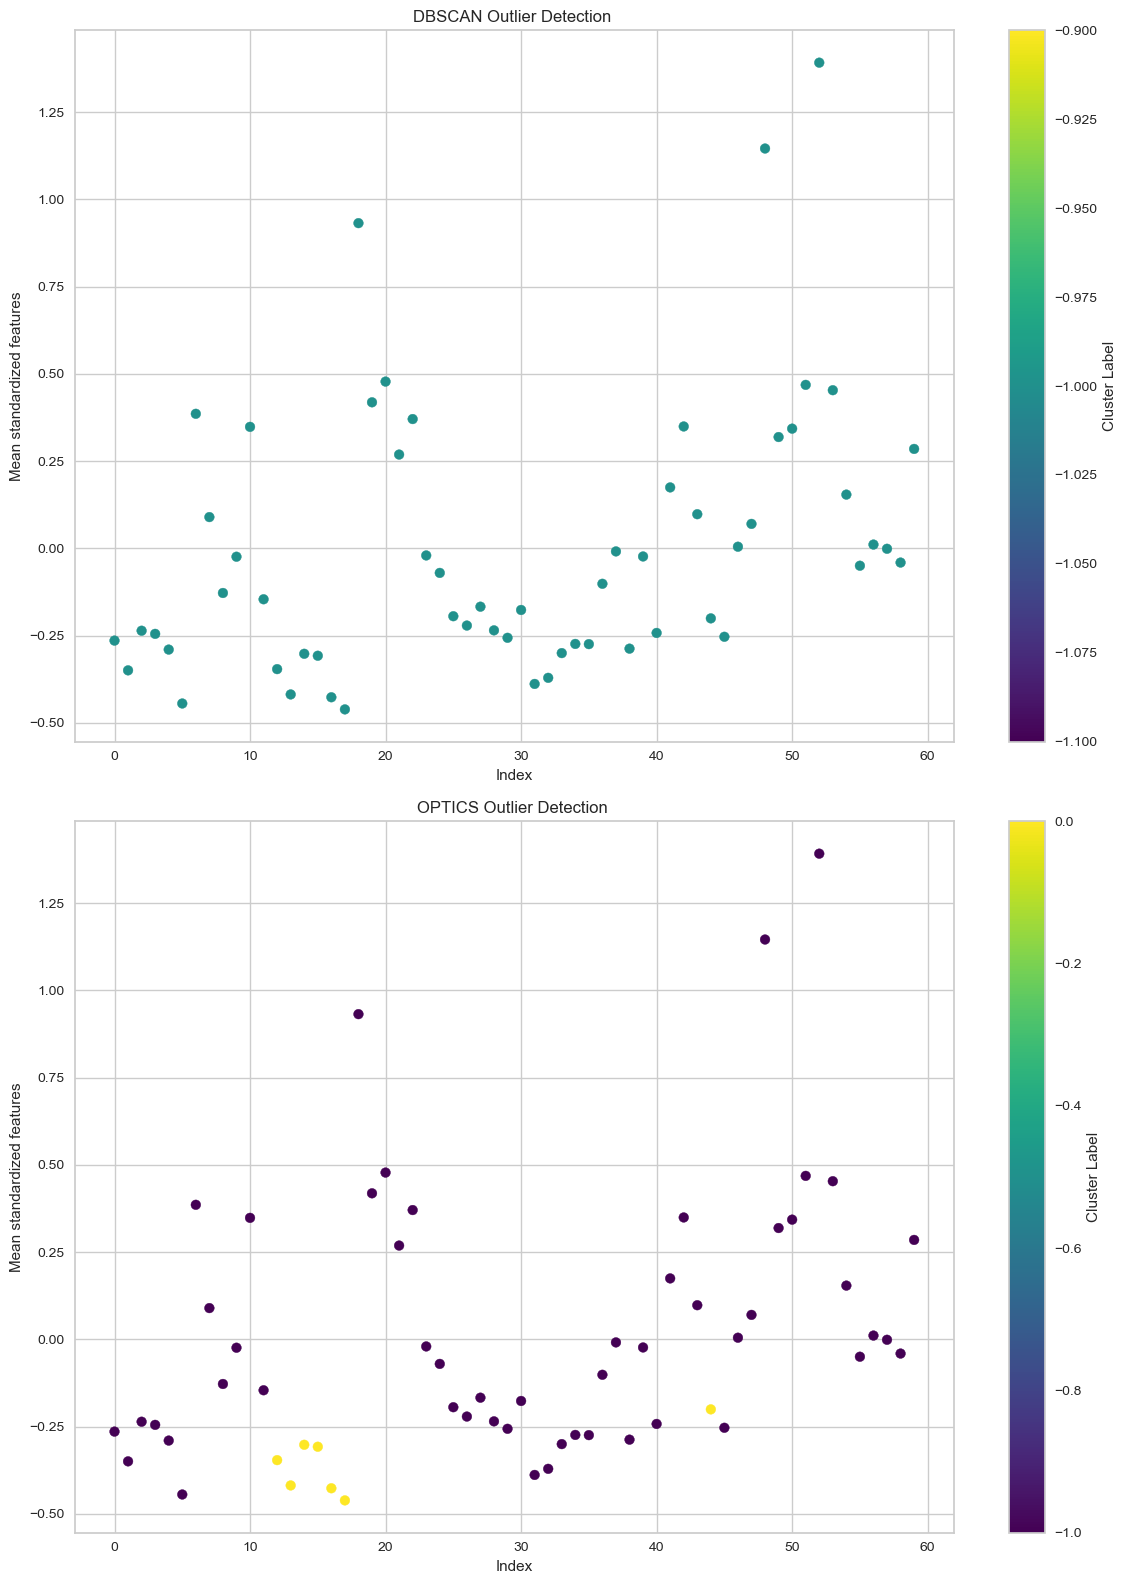

In [9]:
# Function to plot outliers
def outliers_plot(ax, features_df, outliers, model='', extra_feature=''):
    scatter = ax.scatter(range(len(features_df)), features_df.mean(axis=1), c=outliers, cmap='viridis')
    ax.set_xlabel('Index')
    ax.set_ylabel('Mean standardized features')
    ax.set_title(f'{model} Outlier Detection {extra_feature}')
    plt.colorbar(scatter, ax=ax, label='Cluster Label')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_standardized)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
outliers_dbscan = dbscan.fit_predict(features_imputed)

# Apply OPTICS clustering
optics = OPTICS(min_samples=5)
labels_optics = optics.fit_predict(features_imputed)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Visualization for DBSCAN
outliers_plot(axes[0], features_imputed, outliers_dbscan, 'DBSCAN')

# Visualization for OPTICS
outliers_plot(axes[1], features_imputed, labels_optics, 'OPTICS')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Extract outliers (data points labeled as -1 by OPTICS)
outliers_indices_optics = np.where(labels_optics == -1)[0]
outliers_optics = features_imputed[outliers_indices_optics]


**Joint Histograms**

There are many features to be analyzed, when performing the pairplot it lasts too much. To avoid this lines of code, the sns.displot() function can provide the same information for the two selected features that there's interest in visualize. 

In [10]:
# There are many different features and the pairplot takes a lot of time in order to appear on the screen. This information will be seen throught the correlation 
#matrix and the different plots performed to analyze the data. 

# pairplot 
# g = sns.pairplot(data, hue="SUPINATION")

**Correlation Matrix**

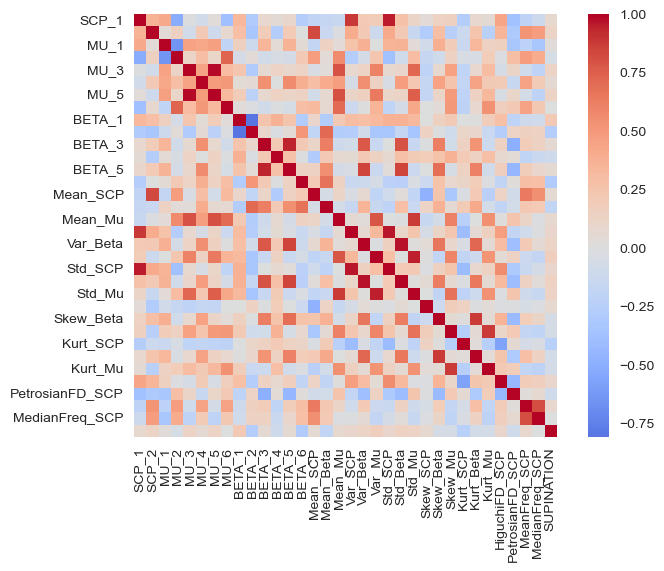

In [11]:
corrmat = df_data_filled.corr(numeric_only=True)
sns.heatmap(corrmat, annot=False, square=True, cmap="coolwarm", center=0);

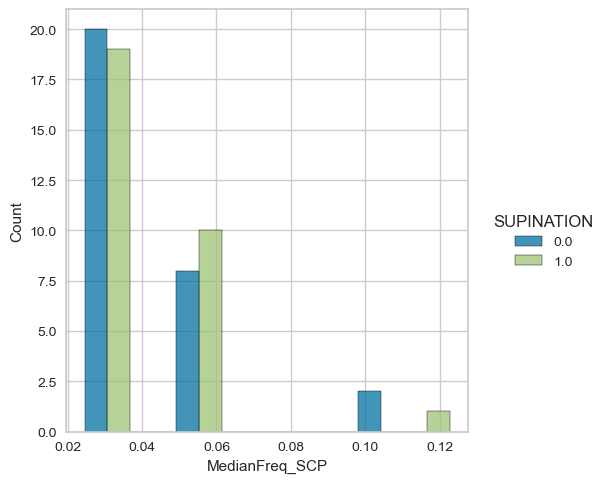

In [12]:
# HERE WE SHOULD CHOOSE THE DATA THAT WE ARE INTERESTED IN VISUALIZING, CURRENTLY IS PLACED WITH THE SCP_1 (PEAK TO PEAK VALUE)!!! 

sns.displot(df_data_filled, x="MedianFreq_SCP", hue="SUPINATION", multiple="dodge",
            facet_kws={'despine': False});

**Density Plot**

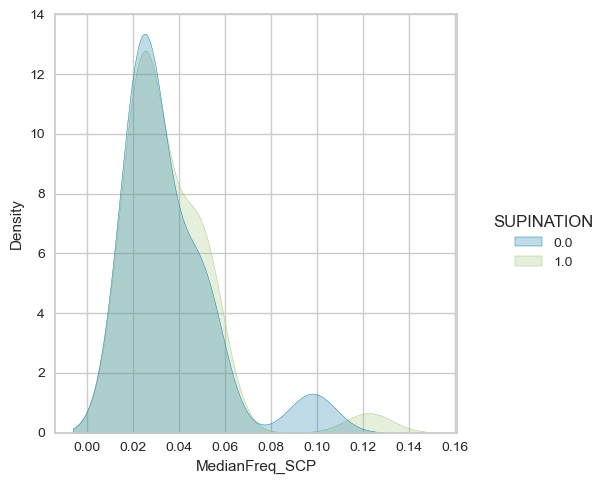

In [13]:
# HERE WE SHOULD CHOOSE THE DATA THAT WE ARE INTERESTED IN VISUALIZING, CURRENTLY IS PLACED WITH THE SCP_1 (PEAK TO PEAK VALUE)!!! 

sns.displot(df_data_filled, x="MedianFreq_SCP", hue="SUPINATION", kind="kde",
            fill=True, facet_kws={'despine': False});

From the information earned by the last plots and the correlation matrix, some further investigation has been performed for the interesting features and the logarithm of them, to see if the results where better. 

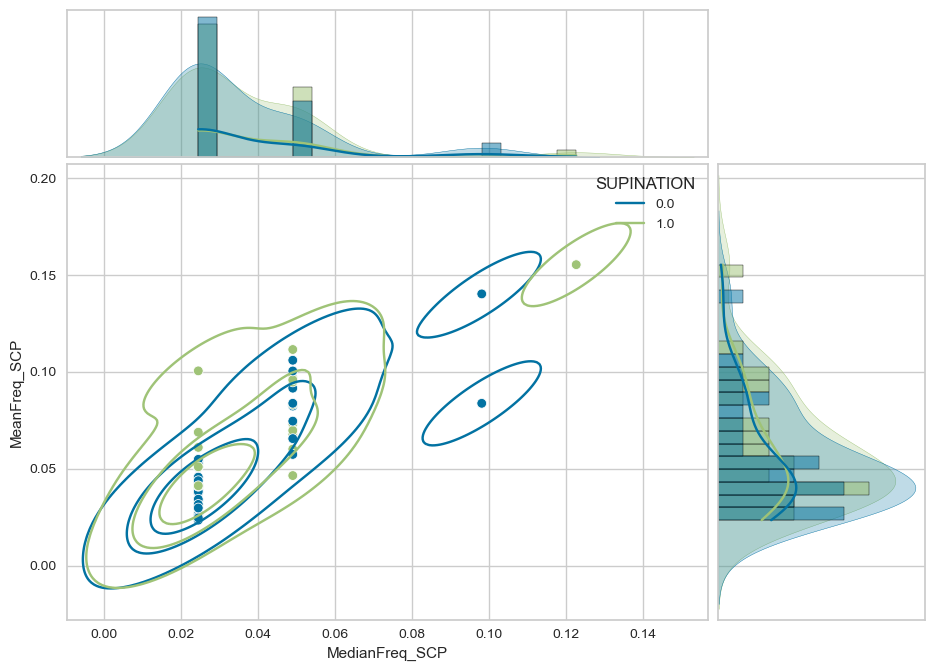

In [14]:
g = sns.jointplot(data=df_data_filled, x="MedianFreq_SCP", y="MeanFreq_SCP", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

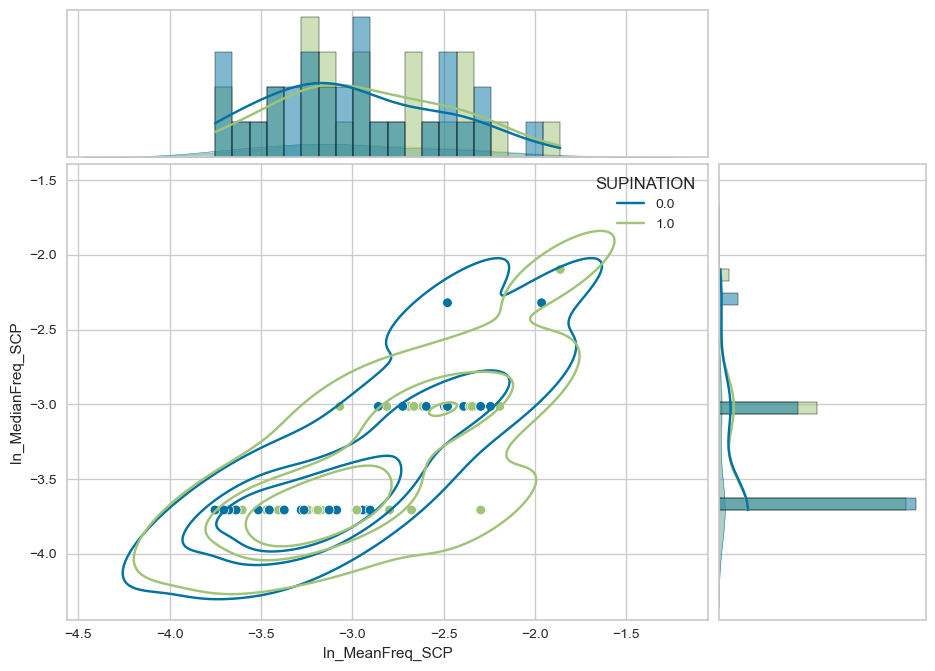

In [15]:
df_data_filled['ln_MeanFreq_SCP'] = np.log(df_data_filled['MeanFreq_SCP'])
df_data_filled['ln_MedianFreq_SCP'] = np.log(df_data_filled['MedianFreq_SCP'])


g = sns.jointplot(data=df_data_filled, x="ln_MeanFreq_SCP", y="ln_MedianFreq_SCP", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

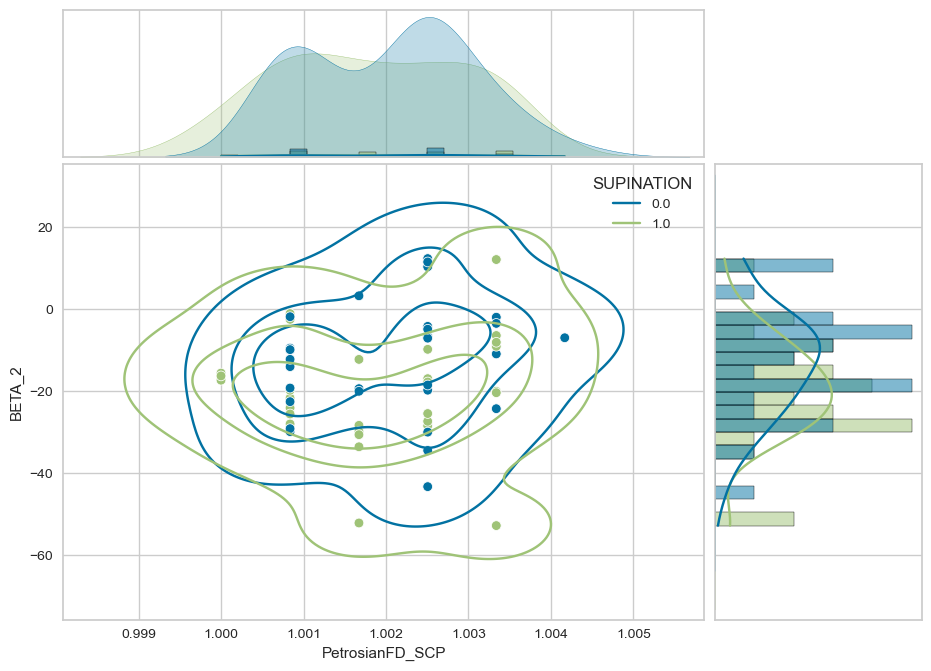

In [16]:
g = sns.jointplot(data=df_data_filled, x="PetrosianFD_SCP", y="BETA_2", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

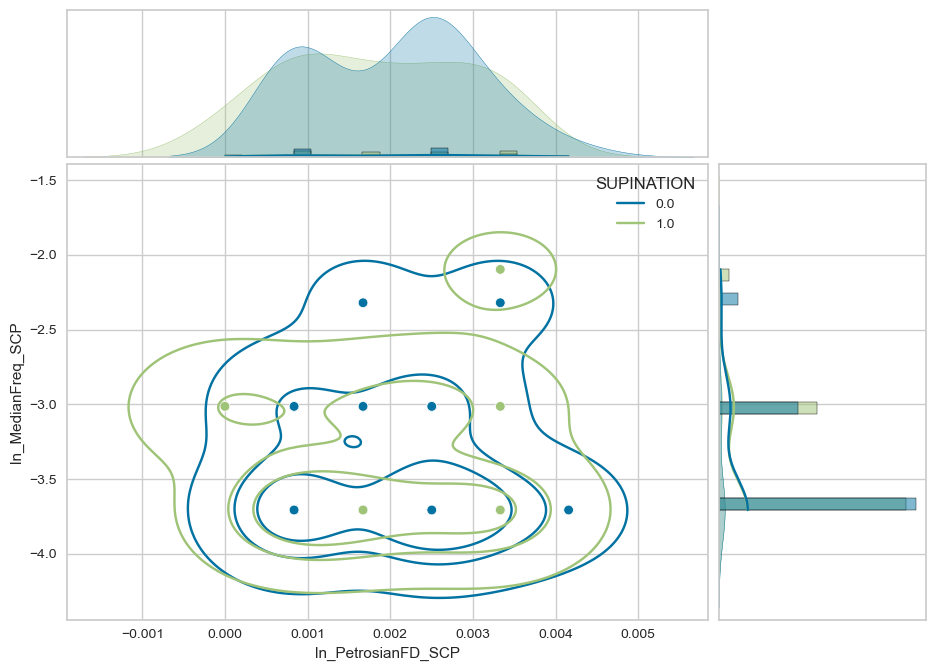

In [17]:
df_data_filled['ln_PetrosianFD_SCP'] = np.log(df_data_filled['PetrosianFD_SCP'])
#df_data_filled['ln_SCP_1'] = np.log(df_data_filled['SCP_1'])

g = sns.jointplot(data=df_data_filled, x="ln_PetrosianFD_SCP", y="ln_MedianFreq_SCP", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

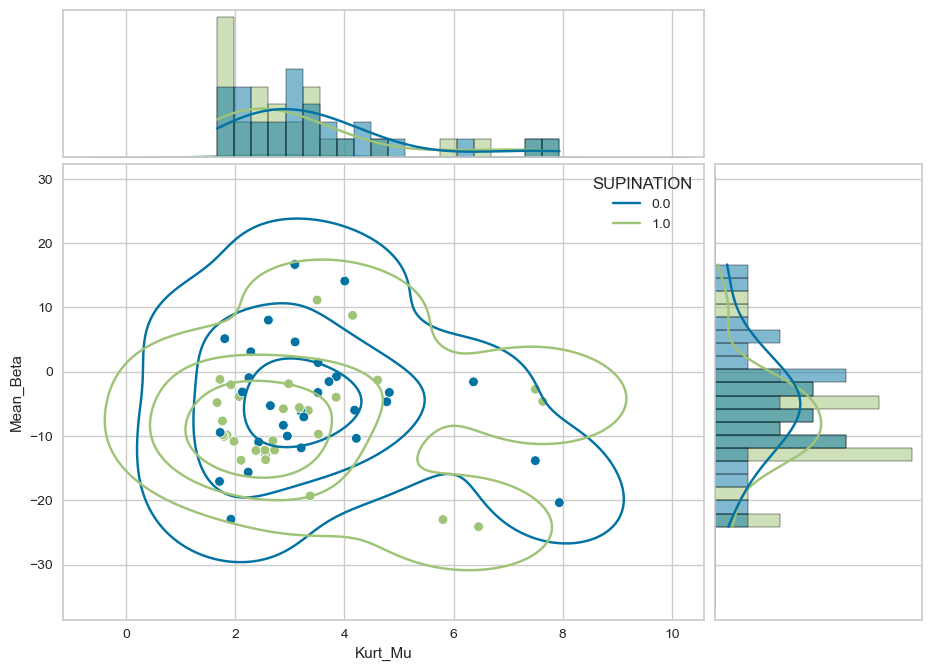

In [18]:
g = sns.jointplot(data=df_data_filled, x="Kurt_Mu", y="Mean_Beta", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

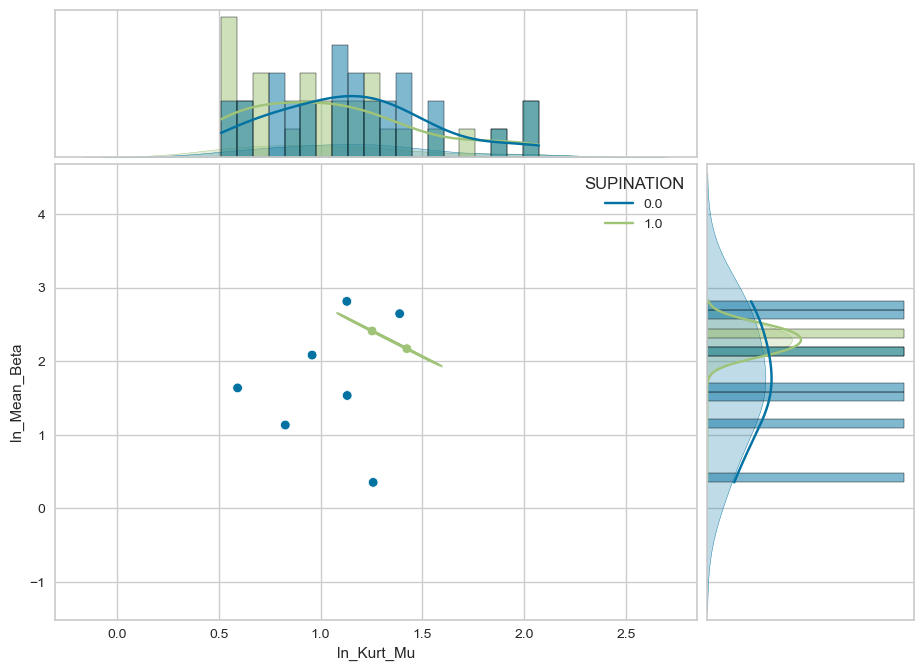

In [19]:
df_data_filled['ln_Kurt_Mu'] = np.log(df_data_filled['Kurt_Mu'])
df_data_filled['ln_Mean_Beta'] = np.log(df_data_filled['Mean_Beta'])

g = sns.jointplot(data=df_data_filled, x="ln_Kurt_Mu", y="ln_Mean_Beta", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

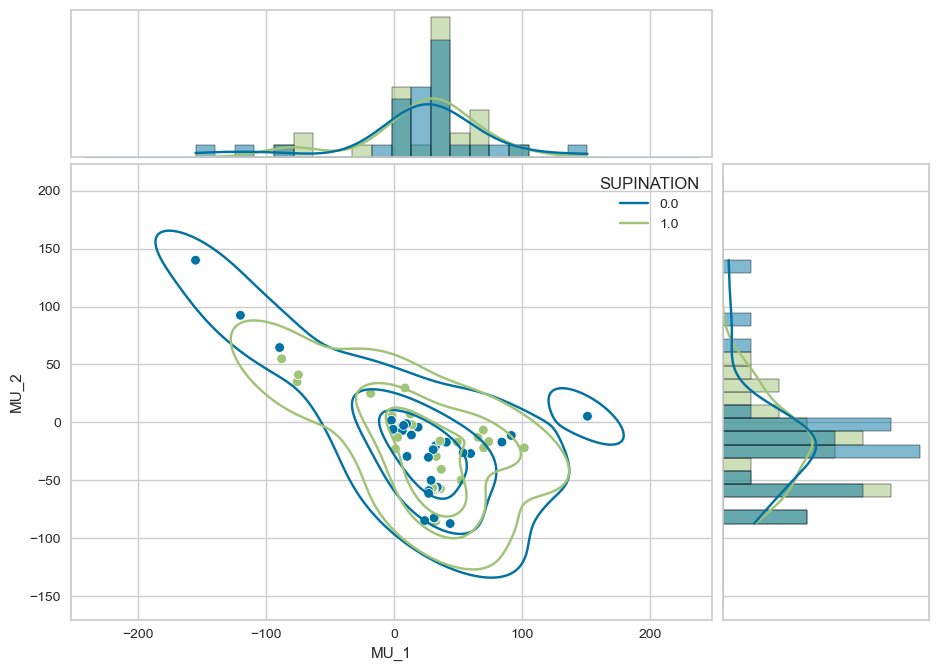

In [20]:
g = sns.jointplot(data=df_data_filled, x="MU_1", y="MU_2", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

Negative correlation found (going down from left to right)

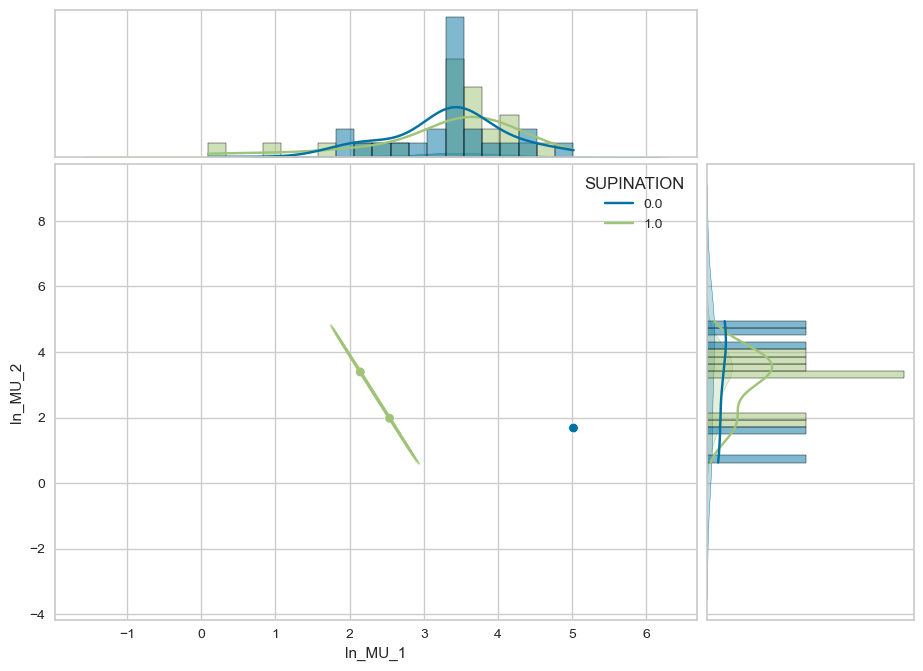

In [21]:
df_data_filled['ln_MU_1'] = np.log(df_data_filled['MU_1'])
df_data_filled['ln_MU_2'] = np.log(df_data_filled['MU_2'])

g = sns.jointplot(data=df_data_filled, x="ln_MU_1", y="ln_MU_2", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

No correlation was found here

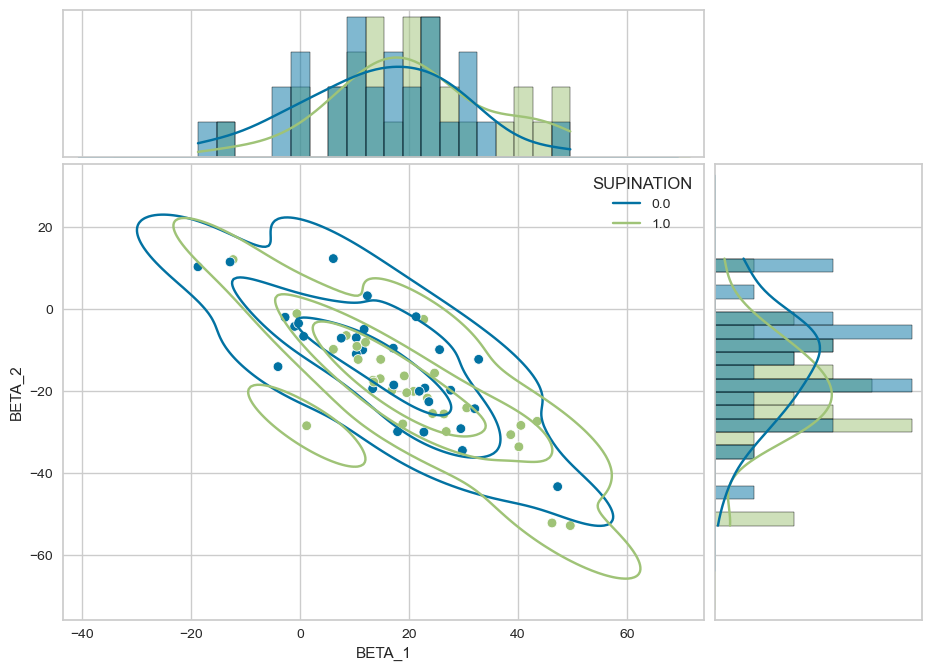

In [22]:
g = sns.jointplot(data=df_data_filled, x="BETA_1", y="BETA_2", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

Negative correlation found here

IndexError: cannot do a non-empty take from an empty axes.

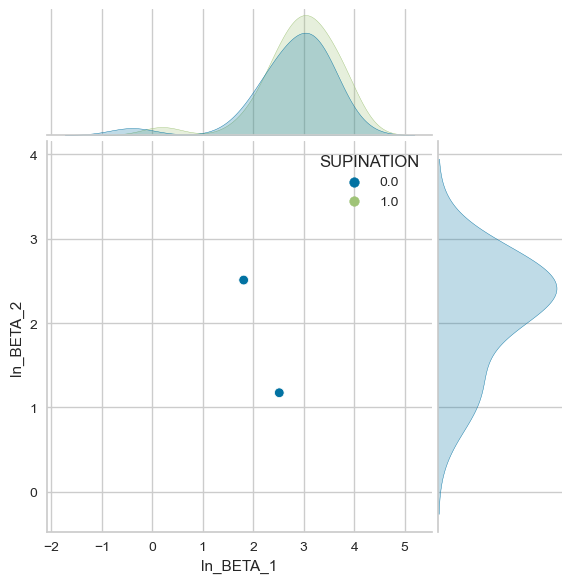

In [23]:
df_data_filled['ln_BETA_1'] = np.log(df_data_filled['BETA_1'])
df_data_filled['ln_BETA_2'] = np.log(df_data_filled['BETA_2'])

g = sns.jointplot(data=df_data_filled, x="ln_BETA_1", y="ln_BETA_2", hue="SUPINATION", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

No correlation found 

### Given the results shown here, the features selected for the next steps will be: 

-
-
-

<div class="alert alert-info" role="alert", style="border-radius: 70px">
    <h2 style="text-align: center; margin-top:0.5cm; margin-bottom:0.5cm; font-size:20px">PART 3. Model Training, Hyperparameter tuning</h2>
</div>

Given our features selection and the characteristics of our data, the first thing to choose is select what approach will be followed.

- Hold-out method: data is splitted into training and testing. This method is straightforward but can lead to high variance in performance estimation, especially with smaller datasets. 

- Cross validation: data is divided into 'k' subsets, and the model is trained and evaluated 'k' times, each time using a different fold as the testing set and the rest as the training set. This method provides a more reliable performance than the previous method and it's good for smaller. It helps in selecting the best model and hyperparameters while minimizing the risk of overfitting. datasets.
  
- Different approach (for example Repeated Cross-Validation): Repeats the k-fold cross-validation multiple times with different random splits and averages the results, providing even more robust performance estimates.

The first thing that must be done in order to be sure that the data is balanced consists on feature scaling, this is done with the following code: 

In [ ]:

# Divide dataset into features and target
X = df_data_filled[['SCP_1', 'SCP_2', 'MU_1', 'MU_2', 'MU_3','MU_4','MU_5','MU_6','BETA_1', 'BETA_2', 'BETA_3','BETA_4','BETA_5','BETA_6','Mean_Mu','Var_SCP','Var_Beta','Var_Mu','Std_SCP','Std_Beta','Std_Mu','Skew_SCP','Skew_Beta','Skew_Mu','Kurt_SCP','Kurt_Beta','Kurt_Mu','HiguchiFD_SCP','PetrosianFD_SCP','MeanFreq_SCP','MedianFreq_SCP']]
y = df_data_filled[['SUPINATION']]

# Feature scaling
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Convert to dataframe
df_hfo_PAT1_st = pd.DataFrame(X_scaled,columns=X.columns)
df_hfo_PAT1_st = pd.concat([df_hfo_PAT1_st, y], axis=1)


One question that will appear once we have our data is in how many clusters should we divide it to have good results using clustering and classification methods later on. To do so, the **Elbow Method** allows a detection of the optimum number of clusters with the following lines of code:

In [ ]:
km = KMeans(n_init="auto")
elbow = KElbowVisualizer(km, k=(1, 6))
elbow.fit(X_scaled)
elbow.show();

### ANALYZE RESULTS 

Once we know the optimum k number of clusters, we can proceed with the different algorithms that have to be followed. If we want to visualize if the clustering division is performed on a balanced way between the different groups,some silhuette plots can be performed.

In [ ]:
# Set figure layout
fig4 = plt.figure(constrained_layout=True, figsize=(12, 12))
gs = fig4.add_gridspec(3, 2)
ax411 = fig4.add_subplot(gs[0, 0])
ax412 = fig4.add_subplot(gs[0, 1])
ax413 = fig4.add_subplot(gs[1, 0])
ax421 = fig4.add_subplot(gs[1, 1])
ax_list = [ax411, ax412, ax413, ax421]

# Evaluate silhouette plots for 2 to 5 clusters
for i, n_clusters in enumerate(range(2, 6)):
    km = KMeans(n_clusters, n_init="auto", random_state=42)
    viz = SilhouetteVisualizer(km, ax=ax_list[i],
                               colors='yellowbrick')
    viz.fit(X)
    viz.finalize()
    viz.ax.set_title(
        f"{n_clusters} clusters, average score = {viz.silhouette_score_:0.3f}")
    viz.ax.set_xlabel("silhouette score")

### ANALYZE RESULTS 

### ALGORITHM TRIALS 

Once the expected number of clusters is ...



seen that coincides with the optimum number of clusters (two clusters, one for supination the other one for closing hand), some algorithms can be tested in order to visualize if the data can be divided into clusters similar to the labels that were created on the feature extraction section. 

#### K-Means

The first method used is K-Means. This method minimizes the variance within each cluster, creating clusters of data points that are similar to each other. The amount of clusters will depend on the number of '*K*' initial centroids that will be chosen randomly from all the data. The following code implements the K-Means method. 

In [ ]:
# Fit clustering and extract assigned clusters
# MODIFY THE NUMBER OF CLUSTERS ACCORDING TO THE OPTIMUM NUMBER OF CLUSTERS SHOWN ON THE ELBOW METHOD!!!! 
km2 = KMeans(n_clusters=2, n_init="auto", random_state=42)
km2.fit(X_scaled)
df_data_filled['2-means'] = km2.labels_

# Define the mapping from numeric labels to string labels
label_map = {0.0: 'CLOSE HAND', 1.0: 'SUPINATION'}

# Map the numeric labels to string labels
df_data_filled['SUPINATION_str'] = df_data_filled['SUPINATION'].map(label_map)

# Adjusted plotting function with simplified steps
def plot_data_clusters(ax, df_data_filled, x, y, hue, title):
    # Check if hue is a list or array (indicating cluster labels)
    if isinstance(hue, (list, np.ndarray)):
        df_data_filled['cluster_labels'] = hue
        hue = 'cluster_labels'
    
    print(f"Plotting {title} with hue: {hue}")
    print(df_data_filled[[x, y, hue]].dropna().head())  # Print first few rows of data to be plotted

    sns.scatterplot(data=df_data_filled,
                    x=x, y=y,
                    hue=hue,
                    palette="deep",
                    ax=ax)
    ax.set_title(title, size=14)

    # Adding KDE plot separately to handle potential issues
    try:
        sns.kdeplot(data=df_data_filled,
                    x=x, y=y,
                    hue=hue,
                    alpha=0.5,
                    levels=3,
                    palette="deep",
                    ax=ax)
    except Exception as e:
        print(f"Failed to plot KDE: {e}")


In [ ]:
print(df_data_filled.head())
print(df_data_filled[['SCP_1', 'SUPINATION', 'SUPINATION_str', '2-means']].info())

In [ ]:
# Create a figure to compare labels and clusters
fig1, (ax11, ax12) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax11, df_data_filled, 'ln_Kurt_Mu', 'SUPINATION', 'SUPINATION_str', 'Labelled Data')

# Plot clustered data
plot_data_clusters(ax12, df_data_filled, 'ln_Kurt_Mu', 'SUPINATION', '2-means', 'Clustered Data')

#### Hierarchical Clustering

The second method tested is Hierarchical Clustering, which aims to build a hierarchy of clusters. For this part, the Agglomerative (Bottom-Up) Approach was chosen. This approach starts with each data point as its own cluster and iteratively merges the closest pairs of clusters until all data points belong to a single cluster.

In [ ]:
# REMEMBER TO CHANGE THE NUMBER OF CLUSTERS ACCORDING TO THE OPTIMUM NUMBER THAT HAS
#BEEN OBTAINED PREVIOUSLY
agg = AgglomerativeClustering(n_clusters=2,
                              metric='euclidean',
                              linkage='ward')
agg.fit(X_scaled)

# Create a figure to compare labels and clusters
fig5, (ax51, ax52) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax51, df_data_filled, 'ln_Kurt_Mu', 'SUPINATION', 'SUPINATION_str', 'Labelled Data')
# Add clustering labels to the dataset for plotting
data['Cluster'] = agg.labels_

# Map clusters to labels for the hue in the plot (if needed, otherwise use numbers directly)
cluster_label_map = {0: 'Cluster 0', 1: 'Cluster 1'}
data['Cluster_str'] = data['Cluster'].map(cluster_label_map)

# Plot clustered data
plot_data_clusters(ax52, df_data_filled,  'ln_Kurt_Mu', 'SUPINATION', '2-means', 'Clustered Data')

# Show the plot
plt.show()

#### Density Based Clustering

The third block of clustering methods used for this clustering analysis consists on Density Based Clustering, which are divided into two different methods:

**DBSCAN**

This method identifies clusters based on the density of data points. It starts with an arbitrary point and explores its neighborhood to see if it has enough points (defined by the parameters 'eps' for neighborhood radius and 'minPts' for minimum points). If the point is within a dense region, it is marked as a core point, and the algorithm expands from this point to form a cluster by recursively including all density-reachable points.

Points not reachable within the density criteria are labeled as noise. This method is effective for discovering clusters of arbitrary shape and handling outliers well.

In [ ]:
# Fit DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=15)
dbscan.fit(X_scaled)

# Create a figure to compare labels and clusters
fig6, (ax61, ax62) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 7))

# Plotting labelled data
plot_data_clusters(ax61, df_data_filled, 'ln_Kurt_Mu', 'SUPINATION', 'SUPINATION_str', 'Labelled Data')

# Plot clustered data with cluster labels
plot_data_clusters(ax62, df_data_filled, 'ln_Kurt_Mu', 'SUPINATION', dbscan.labels_, 'Clustered Data')

plt.show()

**OPTICS**

This method is very similar to the DBSCAN method but provides additional insights into the cluster structure by ordering points based on their density. It generates a reachability plot, which shows the density-based ordering of points, allowing the identification of clusters with varying densities. Instead of producing a single clustering result, OPTICS provides a density-based cluster ordering, which helps in visualizing and identifying clusters at different density levels.

OPTICS can be seen as a generalization of DBSCAN that works well for clusters with varying densities.

In [ ]:
# Fit OPTICS clustering
optics = OPTICS(min_samples=15, xi=0.15, min_cluster_size=0.15)
optics.fit(X_scaled)

# Create a figure to compare labels and clusters
fig6, (ax61, ax62) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax61, df_data_filled, 'ln_Kurt_Mu', 'SUPINATION', 'SUPINATION_str', 'Labelled Data')

# Plot clustered data with cluster labels
plot_data_clusters(ax62, df_data_filled, 'ln_Kurt_Mu', 'SUPINATION', dbscan.labels_, 'Clustered Data')

# Show the plot
plt.show()

## CLASSIFICATION

Once the dataset has been studied and analyzed if the different clustering methods are good options to separate into groups the different points some classification algorithms have been tested in order to find an improvement on the previous results. 

The first thing that must be done when working with classification algorithms is to divide the dataset into **Training and Testing**. For this purpose the dataset has been divided into 60% Training and 40% Test. In order to do this in python, the following code has been used. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from pathlib import Path
from sklearn.impute import SimpleImputer

from yellowbrick.model_selection import ValidationCurve, LearningCurve, validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from yellowbrick.classifier import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Divide dataset into train and test subsets
selected_predictors = ['SCP_1', 'SCP_2', 'MU_1', 'MU_2', 'MU_3','MU_4','MU_5','MU_6','BETA_1', 'BETA_2', 'BETA_3','BETA_4','BETA_5','BETA_6','Mean_Mu','Var_SCP','Var_Beta','Var_Mu','Std_SCP','Std_Beta','Std_Mu','Skew_SCP','Skew_Beta','Skew_Mu','Kurt_SCP','Kurt_Beta','Kurt_Mu','HiguchiFD_SCP','PetrosianFD_SCP','MeanFreq_SCP','MedianFreq_SCP', 'ln_MU_1']
X = df_data_filled[selected_predictors]
y = df_data_filled['SUPINATION']

# Split the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Impute missing values instead of dropping, when dropping some issues appeared
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

Once the dataset is been separated between Training and Testing data, some algorithms can be tested in order to visualize the accuracy and analyze the results obtained. 

### CLASSIFICATION ALGORITHMS

In [ ]:
# Definition of functions used on the different algorithms. Mostly used to analyze the results analytically and visually. 

def study_model(model, X, y, param_name,param_range):
    
    sizes = np.linspace(0.1, 1.0, 10)    
        
    # Validation curve

    vc = ValidationCurve(
        model, param_name=param_name,
        param_range=param_range, cv=10, scoring="r2"
    )
       
        
    vc.fit(X, y)
    vc.show()

    # Learning Curve
    lc = LearningCurve(
        model, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
    )

    lc.fit(X, y)
    lc.show()           

    return model
    
def binary_classification(model, X_train, y_train, X_test, y_test):
    # Train model, use it to predict
    y_pred = model.fit(X_train, y_train).predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Calculate evaluation metrics
    cm = confusion_matrix(model,
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      is_fitted=True,
                      support=True,
                      cmap='RdYlGn')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Display results
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Roc AUC score:", roc_auc)
    
    # Roc curve
    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
        
    # Classification report
    print(classification_report(y_pred, y_test))
    
    return model

**LDA** 

The first classifier used is the **Linear Discriminant Analysis (LDA)**. This method projects high-dimensional data onto a lower-dimensional space with good-class separability. It assumes that different classes generate data based on Gaussian distributions with a shared covariance matrix. LDA aims to find a linear combination of features that best separates the classes, making it useful for dimensionality reduction and as a classifier for supervised learning tasks.

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report


# Instanciate model
lda_2 = LinearDiscriminantAnalysis(solver='lsqr')

# Train model and use it to predict
y_pred = lda_2.fit(X_train_imputed, y_train).predict(X_test_imputed)


study_model(lda_2, X_train_imputed, y_train,'shrinkage',np.linspace(0.1, 1, 20))

# Create confusion matrix
cm = ConfusionMatrix(lda_2, cmap='RdYlGn')
cm.fit(X_train_imputed, y_train)
cm.score(X_test_imputed, y_test)
cm.show()

# Classification report
print(classification_report(y_test, y_pred))

*LDA ROC and precision-call curves*

In [ ]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

# ROC CURVE 
# Fit visualizer to our classifier
roc_viz = ROCAUC(lda_2,
                 is_fitted=True,
                 per_class=True,
                 micro=False,
                 macro=False,
                 size=(900, 500))
roc_viz.fit(X_train_imputed, y_train)
roc_viz.score(X_test_imputed, y_test)
roc_viz.show();

In [ ]:
from sklearn.preprocessing import LabelEncoder

# PRECISION-RECALL CURVE

# Encode the target (we'll use the encoder to retrieve the class labels)
encoder = LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)

# Create the visualizer
pr_viz = PrecisionRecallCurve(lda_2,
                              classes=encoder.classes_,
                              iso_f1_curves=True,
                              per_class=True,
                              micro=False,
                              size=(900, 500))

# Fit model (we need one-versus-rest classifiers
# to produce binary comparisos for each class)
pr_viz.fit(X_train_imputed, y_train)

# Calculate scores and show them
pr_viz.score(X_test_imputed, y_test)
pr_viz.show();

**Naive Bayes**

The second classifier used is the Naive Bayes. This classifier consists on a simple but powerful machine learning algorithm based on the Baye's theorem and assumes independence between features. It calculates the probability that a given data point belongs to a particular class based on the probability of features ocurring in each class. 

In [ ]:
def evaluate_classifier(model, X_train_imputed, y_train, X_test_imputed, y_test):
    # Train model, use it to predict
    y_pred = model.fit(X_train_imputed, y_train).predict(X_test_imputed)

    cm = confusion_matrix(model,
                          X_train_imputed,
                          y_train,
                          X_test_imputed,
                          y_test,
                          is_fitted=True,
                          support=True,
                          cmap='RdYlGn')

    # Classification report
    print(classification_report(y_pred, y_test))
    
    return model


# Evaluate model
evaluate_classifier(GaussianNB(), X_train_imputed, y_train, X_test_imputed, y_test);

**Logistic Regression**

The third classifier method is Logistic Regression. This statistical method uses binary classification tasks to model the relationship between a binary outcome variable and one or more predictor variables by estimating the probability of the outcome. The results are shown between 0 and 1, representing probabilities making it easy to interpret. 

In [ ]:
# I think both ways will obtain the same, but I'm not sure... 

"""
lr = LogisticRegression(solver='liblinear')
study_model(lr, X, y, 'C',np.linspace(0.1, 1, 20))
binary_classification(lr, X_train, y_train, X_test, y_test)
"""

evaluate_classifier(LogisticRegression(solver='newton-cg'),
                    X_train_imputed,
                    y_train,
                    X_test_imputed,
                    y_test);

**KNN**

The fourth classifier used is the K-Neares Neighbors (KNN). It works by finding the '*K*' neares data points to a given query point based on a distance metric (commonly used the Euclidean distance) in the feature space. For classification, the majority class among the K neighbors determines the class of the query point. 

KNN performance strongly depends on the choice of '*K*' and the distance metric. 

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=10)
# study_model(knn, X, y, 'n_neighbors',np.arange(1, 11))
# binary_classification(knn, X_train, y_train, X_test, y_test)


evaluate_classifier(KNeighborsClassifier(n_neighbors=15),
                    X_train_imputed,
                    y_train,
                    X_test_imputed,
                    y_test);


**Decision Tree**

The fifth classifier method used is the Decision Tree. This model has a tree shape where each "*internal*" node represents a feature, each "*branch*" represents a decision rule, ane each "*leaf node*" represents the outcome.

In [ ]:
# Confusion matrix
dt = evaluate_classifier(DecisionTreeClassifier(max_depth=3, random_state=42),
                    X_train_imputed,
                    y_train,
                    X_test_imputed,
                    y_test);

**Random Tree**

The sixth classification algorithm used is the Random Forest. This algorithm consists on a machine learning method that constructs multiple decision trees during training and the outputs are used for the other decision trees. This method provides an improved accuracy and overfitting reduction compared to single decision trees. 

In [ ]:
# rf = RandomForestClassifier(max_depth=2, random_state=0)
# study_model(rf, X, y, 'max_depth',np.arange(1, 11))
# binary_classification(rf, X_train, y_train, X_test, y_test)

# with plt.style.context('default'):  # a silly bug makes us do this to see the tree
#     plt.figure(figsize=(12, 8))
#     plot_tree(dt,
#               impurity=True,
#               feature_names=X_train.columns,
#               class_names=encoder.classes_,
#               fontsize=14,
#               rounded=True,
#               filled=True)

**Support Vector Machine**

The seventh and last method used is the Support Vector Machine (SVM). This supervised learning algorithm finds the hyperplane that best separates data into classes by maximizing the margin between classes. It can handle high-dimensional data and is effective in cases with clear margin separation. 

In [ ]:
# svm_ = SVC(kernel='linear',probability=True)
# study_model(svm_, X, y, 'gamma',np.logspace(-3, 3, 10))
# binary_classification(svm_, X_train, y_train, X_test, y_test)


# Confusion matrix
evaluate_classifier(SVC(kernel='linear'),
                    X_train_imputed,
                    y_train,
                    X_test_imputed,
                    y_test);

## Automated Machine Learning 

In order to test more methods, an automated Machine Learning has been used to test our results obtained. The one used has been the auto-sklearn 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import autosklearn.classification
from sklearn.metrics import accuracy_score, classification_report

# Create and fit the auto-sklearn classifier
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=3600,  # Time limit in seconds for the search (e.g., 1 hour)
    per_run_time_limit=360,  # Time limit for each model evaluation (e.g., 6 minutes)
    ensemble_size=50,  # Number of models to use in the final ensemble
    seed=42
)

automl.fit(X_train_imputed, y_train)


from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = automl.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

<div class="alert alert-info" role="alert", style="border-radius: 70px">
    <h2 style="text-align: center; margin-top:0.5cm; margin-bottom:0.5cm; font-size:20px">Part 4. Results: testing the classifier on "unseen" EEG</h2>
</div>

<div class="alert alert-info" role="alert", style="border-radius: 70px">
    <h2 style="text-align: center; margin-top:0.5cm; margin-bottom:0.5cm; font-size:20px">Part 5. FINAL CONCLUSION</h2>
</div>